In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [11]:
import random # random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accesso ai file
import datetime # dati temporali (date, ore)
import tensorflow as tf # Per creare reti neurali
import pandas as pd # Tabelle
import matplotlib # Grafici
import matplotlib.pyplot as plt #Grafici
import cv2 # Immagini
import keras # Semplifica la creazione di reti neurali
# from keras.optimizers import Adam # allenatore
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow import keras # idem
from sklearn.model_selection import train_test_split # Divide i dati in training set e test set
from sklearn.preprocessing import LabelEncoder # Converte le parole in numeri ("Gatto" = 0, "Cane" = 1, ...)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Per gestire il dataset di immagini
from keras.models import Sequential # Per definire una rete neurale semplice, sequenziale
from tensorflow.keras import layers # I livelli di una rete neurale
from keras.layers import Dense, Dropout, Activation, Flatten # Componenti di una rete neurale
from keras.layers import Conv2D, MaxPooling2D # Convoluzioni e pooling
import seaborn as sns # Altri grafici
from sklearn.metrics import confusion_matrix # Per capire quanto è bravo il modello
from sklearn.utils import class_weight # Per bilanciare il dataset

In [12]:
def dataset(direct):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()
    
    train_dir = os.listdir(direct)
    for i in train_dir:
        if i == "Train_Test_Valid":
            continue
        class_path = os.path.join(direct, i)
        
        # 디렉터리인지 확인
        if os.path.isdir(class_path):
            classes.append(i)
            for j in os.listdir(class_path):
                file_path = os.path.join(class_path, j)
                img = cv2.imread(file_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, (224, 224))  # Resize image
                    img = img / 255.0  # Normalize
                    images.append(img)
                    labels.append(i)
                
    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

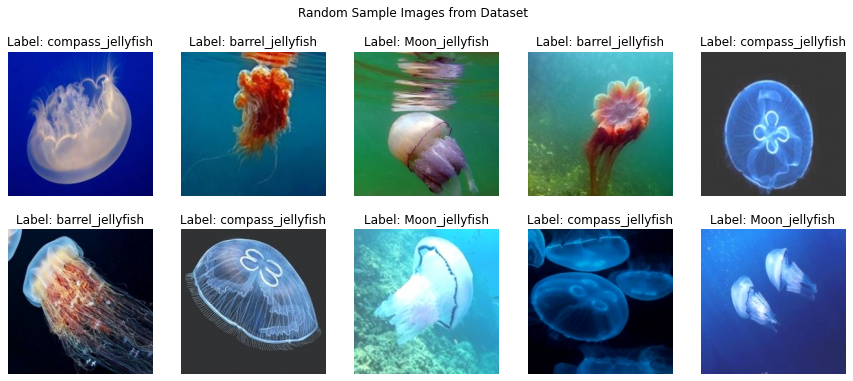

In [13]:
images, labels, classes = dataset('./jellyfish')

random_indexes = random.sample(range(len(images)), 10)

# Plot a few images at random indexes
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in zip(random_indexes, ax.flatten()):
    ax.imshow(images[idx])
    ax.set_title(f"Label: {classes[labels[idx]]}")
    ax.axis('off')
plt.suptitle('Random Sample Images from Dataset')
plt.show()

In [14]:
# training set (80%)  test set (20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# training set (75%)  "validation set" (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

classes = np.unique(classes)

In [15]:
# 데이터 증강 설정 

train_datagen = ImageDataGenerator(
    rotation_range = 10, # 이미지를 최대 10도까지 랜덤하게 회전 
    zoom_range = 0.1, # 이미지를 10%까지 랜덤하게 확대 또는 축소 
    width_shift_range = 0.2, # 이미지를 가로로 20%
    height_shift_range = 0.2, # 세롤로 20%까지 랜덤하게 이동 
    horizontal_flip = True, # 이미지를 좌우로 뒤집음
    vertical_flip = True, # 이미지를 위아래로 뒤집음 
)

test_val_datagen = ImageDataGenerator() # 검증 및 테스트 데이터 생성 설정 
# 검증과 테스트 데이터에는 증강을 적용하지 않음 
# 따라서 단순히 ImageDataGenerator()만 사용하여 원본 이미지를 그대로 사용

# 학습 데이터를 batch_size=20으로 나누어 train_datagen에 설정된 증강을 적용해 학습용 배치를 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=20)

# 검증 데이터를 batch_size=20으로 나누어 증강 없이 생성
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=20)

# 테스트 데이터를 batch_size=20으로 나누어 생성
# shuffle=False로 설정하여 데이터를 랜덤하게 섞지 않음 
# 테스트에서는 예측 결과의 순서가 일정해야 하기 때문에 보통 shuffle=False로 설정
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=20, shuffle=False)

In [16]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [17]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [30]:
def train():
    default_config = {
        "input" : (28,28,1),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model
    
    # 모델 초기화
    
    global model 
    model = Sequential()

    # 첫 번째 convolutional layer
    model.add(Conv2D(16, 3, input_shape=(224, 224, 3), activation='relu'))

    # pooling으로 downsampling 및 convolutional layer 추가 
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(2))

    # 2D metrics를 1D vector로 flattening하여 완전 연결 층 준비 
    model.add(Flatten())
          
    # 완전 연결 층 (flatten된 특징의 비선형 조합을 학습하기 위한 relu)
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
          
    # 출력 층 (다중 클래스 분류 (6개의 클래스)에 적합)
    model.add(Dense(6, activation='softmax'))
  

    # 모델 컴파일 
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    
    # 모델 학습
    global history
    history = model.fit(
    train_generator, 
    epochs=wandb.config.epoch, 
    validation_data=val_generator
    )
    
    
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [31]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_first_CNN_used_by_Jindeok")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: a6523rt3
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_first_CNN_used_by_Jindeok/sweeps/a6523rt3


wandb: Agent Starting Run: czuawi9b with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0648131609217834


Epoch 1/5
27/27 [==============================] - 56s 382ms/step - loss: 1.7757 - accuracy: 0.2185 - val_loss: 1.7180 - val_accuracy: 0.2778
Epoch 2/5
27/27 [==============================] - 5s 194ms/step - loss: 1.7016 - accuracy: 0.2815 - val_loss: 1.6000 - val_accuracy: 0.3556
Epoch 3/5
27/27 [==============================] - 252s 10s/step - loss: 1.6471 - accuracy: 0.2926 - val_loss: 1.6132 - val_accuracy: 0.3444
Epoch 4/5
27/27 [==============================] - 6s 186ms/step - loss: 1.5866 - accuracy: 0.3370 - val_loss: 1.4718 - val_accuracy: 0.3167
Epoch 5/5
9/9 [==============================] - 0s 16ms/step - loss: 1.4485 - accuracy: 0.3944
Test Accuracy: 39.44%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,39.44
Test Error Rate:,60.56


wandb: Agent Starting Run: dhypfm9g with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.026385454963533676


Epoch 1/6
27/27 [==============================] - 6s 195ms/step - loss: 1.9452 - accuracy: 0.2111 - val_loss: 1.7567 - val_accuracy: 0.1389
Epoch 2/6
27/27 [==============================] - 5s 194ms/step - loss: 1.7413 - accuracy: 0.2278 - val_loss: 1.6123 - val_accuracy: 0.3611
Epoch 3/6
27/27 [==============================] - 5s 193ms/step - loss: 1.6100 - accuracy: 0.3556 - val_loss: 1.5307 - val_accuracy: 0.3278
Epoch 4/6
27/27 [==============================] - 5s 189ms/step - loss: 1.5067 - accuracy: 0.3778 - val_loss: 1.5045 - val_accuracy: 0.4278
Epoch 5/6
27/27 [==============================] - 5s 191ms/step - loss: 1.4266 - accuracy: 0.4278 - val_loss: 1.3671 - val_accuracy: 0.4556
Epoch 6/6
9/9 [==============================] - 0s 15ms/step - loss: 1.4036 - accuracy: 0.3667
Test Accuracy: 36.67%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,36.67
Test Error Rate:,63.33


wandb: Agent Starting Run: t7whwgza with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.04006640784996864


Epoch 1/10
27/27 [==============================] - 6s 199ms/step - loss: 1.9882 - accuracy: 0.2167 - val_loss: 1.6730 - val_accuracy: 0.3444
Epoch 2/10
27/27 [==============================] - 5s 192ms/step - loss: 1.6899 - accuracy: 0.3111 - val_loss: 1.5551 - val_accuracy: 0.4222
Epoch 3/10
27/27 [==============================] - 5s 192ms/step - loss: 1.5902 - accuracy: 0.3426 - val_loss: 1.4354 - val_accuracy: 0.4056
Epoch 4/10
27/27 [==============================] - 5s 187ms/step - loss: 1.5509 - accuracy: 0.3426 - val_loss: 1.4759 - val_accuracy: 0.4111
Epoch 5/10
27/27 [==============================] - 5s 192ms/step - loss: 1.4691 - accuracy: 0.3815 - val_loss: 1.3417 - val_accuracy: 0.4333
Epoch 6/10
27/27 [==============================] - 5s 192ms/step - loss: 1.4434 - accuracy: 0.4000 - val_loss: 1.3165 - val_accuracy: 0.4444
Epoch 7/10
27/27 [==============================] - 5s 190ms/step - loss: 1.3714 - accuracy: 0.4611 - val_loss: 1.4232 - val_accuracy: 0.4389
Epoch 

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,40.0
Test Error Rate:,60.0


wandb: Agent Starting Run: da4jtuig with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.027381893487886583


Epoch 1/5
27/27 [==============================] - 6s 197ms/step - loss: 1.7067 - accuracy: 0.2407 - val_loss: 1.6423 - val_accuracy: 0.3722
Epoch 2/5
27/27 [==============================] - 5s 193ms/step - loss: 1.5919 - accuracy: 0.3574 - val_loss: 1.4355 - val_accuracy: 0.3333
Epoch 3/5
27/27 [==============================] - 5s 190ms/step - loss: 1.5034 - accuracy: 0.3407 - val_loss: 1.3886 - val_accuracy: 0.4500
Epoch 4/5
27/27 [==============================] - 5s 187ms/step - loss: 1.4462 - accuracy: 0.3963 - val_loss: 1.3922 - val_accuracy: 0.3889
Epoch 5/5
9/9 [==============================] - 0s 10ms/step - loss: 1.3771 - accuracy: 0.4556
Test Accuracy: 45.56%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,45.56
Test Error Rate:,54.44


wandb: Agent Starting Run: uhgupbx8 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.049496962404167635


Epoch 1/9
27/27 [==============================] - 6s 195ms/step - loss: 1.8278 - accuracy: 0.2074 - val_loss: 1.7225 - val_accuracy: 0.2500
Epoch 2/9
27/27 [==============================] - 5s 191ms/step - loss: 1.7054 - accuracy: 0.2556 - val_loss: 1.6754 - val_accuracy: 0.2556
Epoch 3/9
27/27 [==============================] - 5s 189ms/step - loss: 1.6694 - accuracy: 0.2574 - val_loss: 1.6306 - val_accuracy: 0.3056
Epoch 4/9
27/27 [==============================] - 5s 191ms/step - loss: 1.6660 - accuracy: 0.2796 - val_loss: 1.6484 - val_accuracy: 0.3111
Epoch 5/9
27/27 [==============================] - 5s 192ms/step - loss: 1.5595 - accuracy: 0.3500 - val_loss: 1.4839 - val_accuracy: 0.4111
Epoch 6/9
27/27 [==============================] - 5s 191ms/step - loss: 1.4839 - accuracy: 0.3963 - val_loss: 1.3896 - val_accuracy: 0.4444
Epoch 7/9
27/27 [==============================] - 5s 192ms/step - loss: 1.4366 - accuracy: 0.4074 - val_loss: 1.3116 - val_accuracy: 0.4944
Epoch 8/9
27/

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,42.22
Test Error Rate:,57.78


wandb: Agent Starting Run: cmlbp2xo with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.0902134599070061


Epoch 1/7
27/27 [==============================] - 6s 197ms/step - loss: 1.7746 - accuracy: 0.2278 - val_loss: 1.7770 - val_accuracy: 0.2556
Epoch 2/7
27/27 [==============================] - 5s 190ms/step - loss: 1.6545 - accuracy: 0.3074 - val_loss: 1.5525 - val_accuracy: 0.3389
Epoch 3/7
27/27 [==============================] - 5s 192ms/step - loss: 1.5601 - accuracy: 0.3537 - val_loss: 1.4229 - val_accuracy: 0.4000
Epoch 4/7
27/27 [==============================] - 5s 189ms/step - loss: 1.5501 - accuracy: 0.3296 - val_loss: 1.5534 - val_accuracy: 0.3556
Epoch 5/7
27/27 [==============================] - 5s 190ms/step - loss: 1.4803 - accuracy: 0.3852 - val_loss: 1.5062 - val_accuracy: 0.4222
Epoch 6/7
27/27 [==============================] - 5s 190ms/step - loss: 1.3852 - accuracy: 0.4426 - val_loss: 1.3458 - val_accuracy: 0.4389
Epoch 7/7
9/9 [==============================] - 0s 14ms/step - loss: 1.2287 - accuracy: 0.5167
Test Accuracy: 51.67%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,51.67
Test Error Rate:,48.33


wandb: Agent Starting Run: 24fmwus3 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.012131046099590214


Epoch 1/7
27/27 [==============================] - 6s 196ms/step - loss: 1.7272 - accuracy: 0.2241 - val_loss: 1.5325 - val_accuracy: 0.3111
Epoch 2/7
27/27 [==============================] - 5s 192ms/step - loss: 1.5629 - accuracy: 0.3167 - val_loss: 1.5129 - val_accuracy: 0.3500
Epoch 3/7
27/27 [==============================] - 5s 192ms/step - loss: 1.4898 - accuracy: 0.3444 - val_loss: 1.3421 - val_accuracy: 0.4500
Epoch 4/7
27/27 [==============================] - 5s 190ms/step - loss: 1.4114 - accuracy: 0.3889 - val_loss: 1.2861 - val_accuracy: 0.4556
Epoch 5/7
27/27 [==============================] - 5s 194ms/step - loss: 1.4147 - accuracy: 0.4148 - val_loss: 1.5144 - val_accuracy: 0.3667
Epoch 6/7
27/27 [==============================] - 5s 190ms/step - loss: 1.3132 - accuracy: 0.4685 - val_loss: 1.3385 - val_accuracy: 0.4222
Epoch 7/7
9/9 [==============================] - 0s 16ms/step - loss: 1.3541 - accuracy: 0.3722
Test Accuracy: 37.22%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,37.22
Test Error Rate:,62.78


wandb: Agent Starting Run: nt52zdo9 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.09813540351240216


Epoch 1/10
27/27 [==============================] - 6s 195ms/step - loss: 1.7309 - accuracy: 0.2611 - val_loss: 1.5984 - val_accuracy: 0.3500
Epoch 2/10
27/27 [==============================] - 5s 193ms/step - loss: 1.6353 - accuracy: 0.3185 - val_loss: 1.4959 - val_accuracy: 0.3778
Epoch 3/10
27/27 [==============================] - 5s 189ms/step - loss: 1.5270 - accuracy: 0.3741 - val_loss: 1.4143 - val_accuracy: 0.4222
Epoch 4/10
27/27 [==============================] - 5s 193ms/step - loss: 1.4972 - accuracy: 0.3704 - val_loss: 1.4705 - val_accuracy: 0.4111
Epoch 5/10
27/27 [==============================] - 5s 190ms/step - loss: 1.4115 - accuracy: 0.4111 - val_loss: 1.2850 - val_accuracy: 0.4944
Epoch 6/10
27/27 [==============================] - 5s 189ms/step - loss: 1.3990 - accuracy: 0.4315 - val_loss: 1.3397 - val_accuracy: 0.4444
Epoch 7/10
27/27 [==============================] - 5s 186ms/step - loss: 1.3528 - accuracy: 0.4778 - val_loss: 1.2705 - val_accuracy: 0.4944
Epoch 

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,43.33
Test Error Rate:,56.67


wandb: Agent Starting Run: jkrnxac1 with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.09537620748979848


Epoch 1/5
27/27 [==============================] - 6s 196ms/step - loss: 1.7964 - accuracy: 0.1926 - val_loss: 1.7001 - val_accuracy: 0.2667
Epoch 2/5
27/27 [==============================] - 5s 191ms/step - loss: 1.7048 - accuracy: 0.2519 - val_loss: 1.7648 - val_accuracy: 0.3000
Epoch 3/5
27/27 [==============================] - 5s 187ms/step - loss: 1.6576 - accuracy: 0.2833 - val_loss: 1.5289 - val_accuracy: 0.3556
Epoch 4/5
27/27 [==============================] - 5s 194ms/step - loss: 1.5408 - accuracy: 0.3481 - val_loss: 1.4243 - val_accuracy: 0.3889
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 1.3898 - accuracy: 0.4056
Test Accuracy: 40.56%


Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,40.56
Test Error Rate:,59.44


wandb: Agent Starting Run: om1j6ko3 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.031725313303108


Epoch 1/10
27/27 [==============================] - 6s 197ms/step - loss: 1.7980 - accuracy: 0.1944 - val_loss: 1.7395 - val_accuracy: 0.2278
Epoch 2/10
27/27 [==============================] - 5s 191ms/step - loss: 1.7012 - accuracy: 0.2648 - val_loss: 1.6207 - val_accuracy: 0.2944
Epoch 3/10
27/27 [==============================] - 5s 191ms/step - loss: 1.6217 - accuracy: 0.2815 - val_loss: 1.4864 - val_accuracy: 0.4222
Epoch 4/10
27/27 [==============================] - 5s 188ms/step - loss: 1.5418 - accuracy: 0.3648 - val_loss: 1.4438 - val_accuracy: 0.4556
Epoch 5/10
27/27 [==============================] - 5s 190ms/step - loss: 1.4941 - accuracy: 0.3889 - val_loss: 1.4570 - val_accuracy: 0.4833
Epoch 6/10
27/27 [==============================] - 5s 191ms/step - loss: 1.4403 - accuracy: 0.4185 - val_loss: 1.3400 - val_accuracy: 0.4500
Epoch 7/10
27/27 [==============================] - 5s 189ms/step - loss: 1.4063 - accuracy: 0.4278 - val_loss: 1.3045 - val_accuracy: 0.4889
Epoch 

Test Accuracy Rate:,▁
Test Error Rate:,▁
Test Accuracy Rate:,47.22
Test Error Rate:,52.78


9/9 [==============================] - 0s 15ms/step - loss: 1.3259 - accuracy: 0.4722


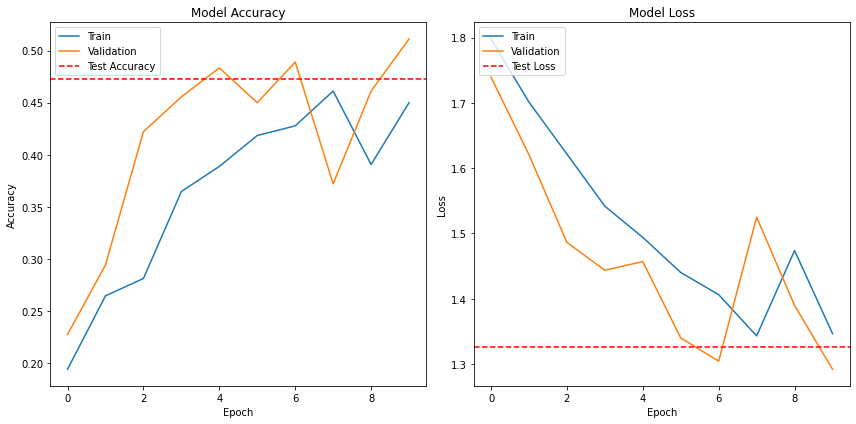

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

test_loss, test_accuracy = model.evaluate(test_generator)
plt.axhline(y=test_accuracy, color='r', linestyle='--')
plt.legend(['Train', 'Validation', 'Test Accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.axhline(y=test_loss, color='r', linestyle='--')
plt.legend(['Train', 'Validation', 'Test Loss'], loc='upper left')

plt.tight_layout()
plt.show()

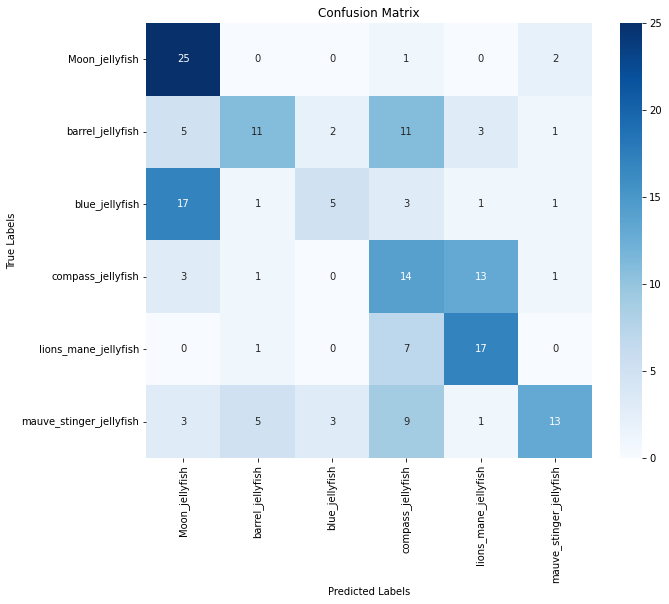

In [50]:



# 실제 라벨과 예측 라벨
y_true = ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish'] * 10  
y_pred = ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish'] * 10  

# 유효한 클래스 이름만 포함
valid_labels = ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 
                'lions_mane_jellyfish', 'mauve_stinger_jellyfish']

# y_true와 y_pred에서 유효하지 않은 라벨 제거
y_true_filtered = [label for label in y_true if label in valid_labels]
y_pred_filtered = [label for label in y_pred if label in valid_labels]


predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = y_test

cm = confusion_matrix(true_labels, predicted_labels)




# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
